In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# DeepTrack

This notebook gives an overview of the capabilities of DeepTrack and how to model optical systems using predifined classes.

## What is DeepTrack?

DeepTrack is fundamentally a framework for generating images. These images may be the output of optical systems, but the framework is capable of generating any image. The main idea of deeptrack is that any image can be viewed as a series of features that takes the an image and updates it according to some rule. A feature can, for example, be adding a particle, introducing some noise, or imaging something through a optical device.

### Features and properties

Features in DeepTrack are classes implementing the Feature class. The way a feature updates an image is governed by the values passed to the class constructor. These inputs are converted to [properties](properties_example.ipynb). An example of a property would be the position of a particle.

In [2]:
from deeptrack.scatterers import PointParticle

particle = PointParticle(
    position=(0, 0),
    position_unit="pixel", # Defaults to meter
    intensity=100,
)

The above code creates a feature (a point particle). This feature will always add a point particle at x=0, y=0. For machine learning, it may be more useful to add a particle at a random position. Then one can instead pass a function that returns a random pair of numbers.

In [3]:
import numpy as np

particle = PointParticle(
    position=lambda: np.random.rand(2) * 64,
    position_unit="pixel",
    intensity=100
)

### Resolving an image

To create an image from a feature, just call its method `.resolve()` with an empty ndarray (all elements zero). To update the properties (here, retrieving a new random position), we call the method `.update()`.

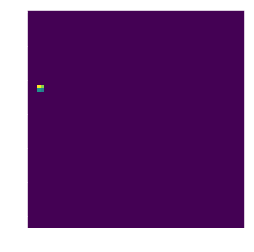

In [4]:
import matplotlib.pyplot as plt

input_image = np.zeros((64, 64))

# Retrieve a new position
particle.update()

# Add the particle to the image
output_image = particle.resolve(input_image)

plt.imshow(output_image)
plt.show();

Notice that the output doesn't look much like a point scatterer. This is because it's not imaged through an optical device. Optical devices are also features, which convolves the input image with a pupil function. They also pass optical properties to features used to generate its input.    

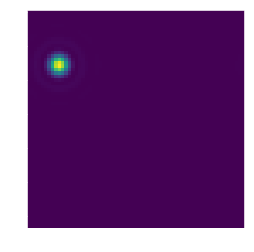

In [5]:
from deeptrack.optics import OpticalDevice

optics = OpticalDevice(
    NA=0.8,
    wavelength=680e-9,
    pixel_size=100e-9
)

# To image a feature, we call optics with the feature
imaged_particle = optics(particle)

imaged_particle.update()
output_image = imaged_particle.resolve(input_image)


plt.imshow(output_image)
plt.show()

### Adding more features

Features can be combined (see [features_example](features_example.ipynb)) using overloaded operators (+, \*, \*\* or ()). Here exemplify the add operator (+) and the power opertor (\*\*).

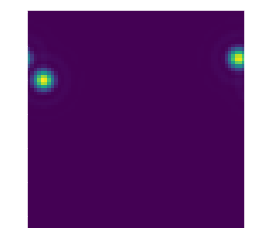

In [6]:
# The + operator
particle_1 = PointParticle(
    position=lambda: np.random.rand(2) * 64,
    position_unit="pixel",
    intensity=100
)

particle_2 = PointParticle(
    position=lambda: np.random.rand(2) * 64,
    position_unit="pixel",
    intensity=100
)

# two_particles is a new feature that first resolves particle_1 and then particle_2, then images it
two_particles = optics(particle_1 + particle_2)

output_image = two_particles.resolve(input_image)

plt.imshow(output_image)
plt.show()

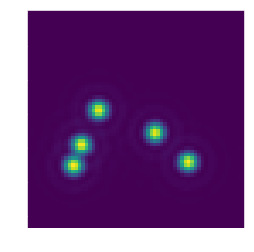

In [7]:
# The ** operator

particle = PointParticle(
    position=lambda: np.random.rand(2) * 64,
    position_unit="pixel",
    intensity=100
)

# five_particles is a feature that resolves five deep copies of particle, then images it
five_particles = optics(particle**5)

output_image = five_particles.resolve(input_image)

plt.imshow(output_image)
plt.show()

### Zero-padding the input

You may have noticed that particles close to edges wrap around to the other side. This is due to the wrap around effect of fourier transform used when convolving an image with a pupil. Two get around this, we zero-pad the input. The desired size can be retrieved in the optics.

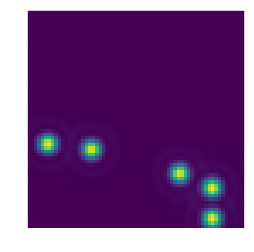

In [8]:
optics = OpticalDevice(
    NA=0.8,
    wavelength=680e-9,
    pixel_size=100e-9,
    ROI = (0, 0, 64, 64) # row, column, height, width
)

five_particles = optics(particle**5)

# Input a slightly larger image as zero padding
input_image = np.zeros((96, 96))

output_image = five_particles.resolve(input_image)

plt.imshow(output_image)
plt.show()

### Adding noise

To make the image more realistic, we can add some noise. Noise can be wrapped by an optical device, but is typically not.

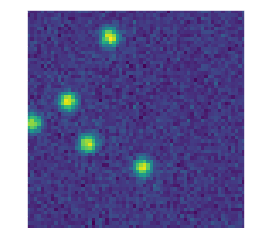

In [9]:
from deeptrack.noises import Offset, Poisson

# Adds a constant value to the background
offset = Offset(offset=10)

# Introduces poisson noise to the image
poisson_noise = Poisson(snr=100)

# noisy_particles resolves five particles, then adds a offset, images it, then introduces poisson noise
noisy_particles = optics(particle**5 + offset) + poisson_noise

output_image = noisy_particles.resolve(input_image)

plt.imshow(output_image)
plt.show()

## Retrieving information about the image

To train a supervised machine learning model, you need labled images. When a features is resolved, it automatically stores the properties of all features used to create the image. This allows us to extract information about the image to use to train machine learning models.

Here we extract the position of all the particles.

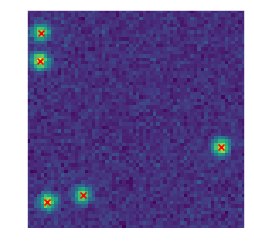

In [10]:
def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = [property_dict["position"] for property_dict in image.properties if "position" in property_dict]
    return np.array(positions)


noisy_particles.update()
output_image = noisy_particles.resolve(input_image)

positions = get_positions(output_image)

plt.imshow(output_image)
plt.scatter(positions[:, 0], positions[:, 1], c="r", marker="x")
plt.show();

## Wrapping features in generators

Generators are ways to continuously resolve new images, and are the prefered interface to machine learning models. The default generator is defined in the Generators module. We can also optionally pass a label function to call on every image.

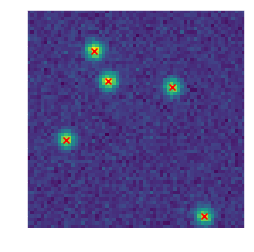

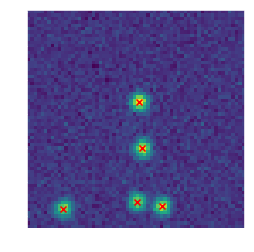

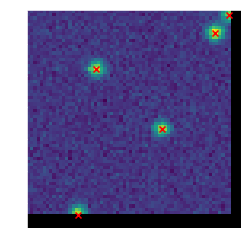

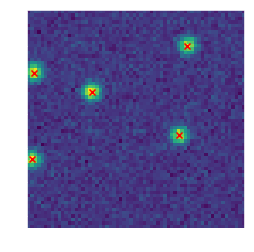

In [11]:
from deeptrack.generators import Generator

generator = Generator().generate(noisy_particles, get_positions, shape=(96,96))

for _ in range(4):
    # Outputs shape (1, height, width, 1)
    next_image, positions = next(generator)
    plt.imshow(np.squeeze(next_image))
    plt.scatter(positions[0, :, 0], positions[0, :, 1], c="r", marker="x")
    plt.show()

## Finally, training a model, complete example

In [12]:
from deeptrack.scatterers import PointParticle
from deeptrack.noises import Offset, Poisson
from deeptrack.optics import OpticalDevice
from deeptrack.generators import Generator
from deeptrack.models import convolutional

# DEFINE FEATURES
optics = OpticalDevice(NA=0.8, wavelength=680e-9, pixel_size=100e-9, ROI=(0, 0, 64, 64))

particle = PointParticle(
    position=lambda: np.random.rand(2) * 64,
    position_unit="pixel",
    intensity=100
)

offset = Offset(
    offset = lambda: np.random.rand() * 20
)

poisson_noise = Poisson(snr=np.linspace(50, 100))

training_set = optics(particle + offset) + poisson_noise


# DEFINE LABEL FUNCTION
def get_position(image):
    for propertydict in image.properties:
        if "position" in propertydict:
            return propertydict["position"] / 64
        
# DEFINE MODEL
tracker = convolutional(input_shape=(64, 64, 1), number_of_outputs=2)

# DEFINE GENERATOR
generator = Generator().generate(training_set, get_position, shape=(96, 96), batch_size=32)



NameError: name 'deeptrackNetwork' is not defined

In [0]:
# TRAIN TRACKER
tracker.fit(generator, epochs=100, steps_per_epoch=10)

In [0]:
batch, labels = next(generator)
predictions = tracker.predict(batch) * 64
for image, position, prediction in zip(batch, labels, predictions):
    plt.gray()
    plt.imshow(image[:, :, 0])
    plt.scatter(position[0], position[1], c='g', marker='x')
    plt.scatter(prediction[0], prediction[1], marker='o', facecolors=None, edgecolors='b')
    plt.show()